In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
import pandas as pd
df = pd.read_csv("D:\IS403_TH\Dataset\AAPL.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,44.634998,44.945000,43.165001,43.750000,41.430168,195208000
1,2018-03-02,43.200001,44.075001,43.112499,44.052502,41.716621,153816000
2,2018-03-05,43.802502,44.435001,43.630001,44.205002,41.861031,113605600
3,2018-03-06,44.477501,44.562500,44.032501,44.167500,41.825520,95154000
4,2018-03-07,43.735001,43.962502,43.567501,43.757500,41.437260,126814000


# Tính tỷ suất

df.Close.pct_change(): Tính toán tỷ lệ thay đổi phần trăm của cột 'Close' so với giá trị trước đó. Phép tính này tính tỷ lệ thay đổi của giá trị tại mỗi hàng so với hàng trước đó.


df.Close/df.Close.shift(1): Tính toán tỷ lệ giá trị của cột 'Close' hiện tại so với giá trị của hàng trước đó.

In [4]:
df['returns'] = 100 * df.Close.pct_change().dropna()
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [5]:
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,returns,log_returns
1,2018-03-02,43.200001,44.075001,43.112499,44.052502,41.716621,153816000,0.691433,0.006891
2,2018-03-05,43.802502,44.435001,43.630001,44.205002,41.861031,113605600,0.346178,0.003456
3,2018-03-06,44.477501,44.562500,44.032501,44.167500,41.825520,95154000,-0.084837,-0.000849
4,2018-03-07,43.735001,43.962502,43.567501,43.757500,41.437260,126814000,-0.928284,-0.009326
5,2018-03-08,43.869999,44.279999,43.767502,44.235001,41.889442,95096400,1.091244,0.010853


**Vẽ đồ thị của cột Returns, Log Returns và phân phối
chuẩn của chúng**















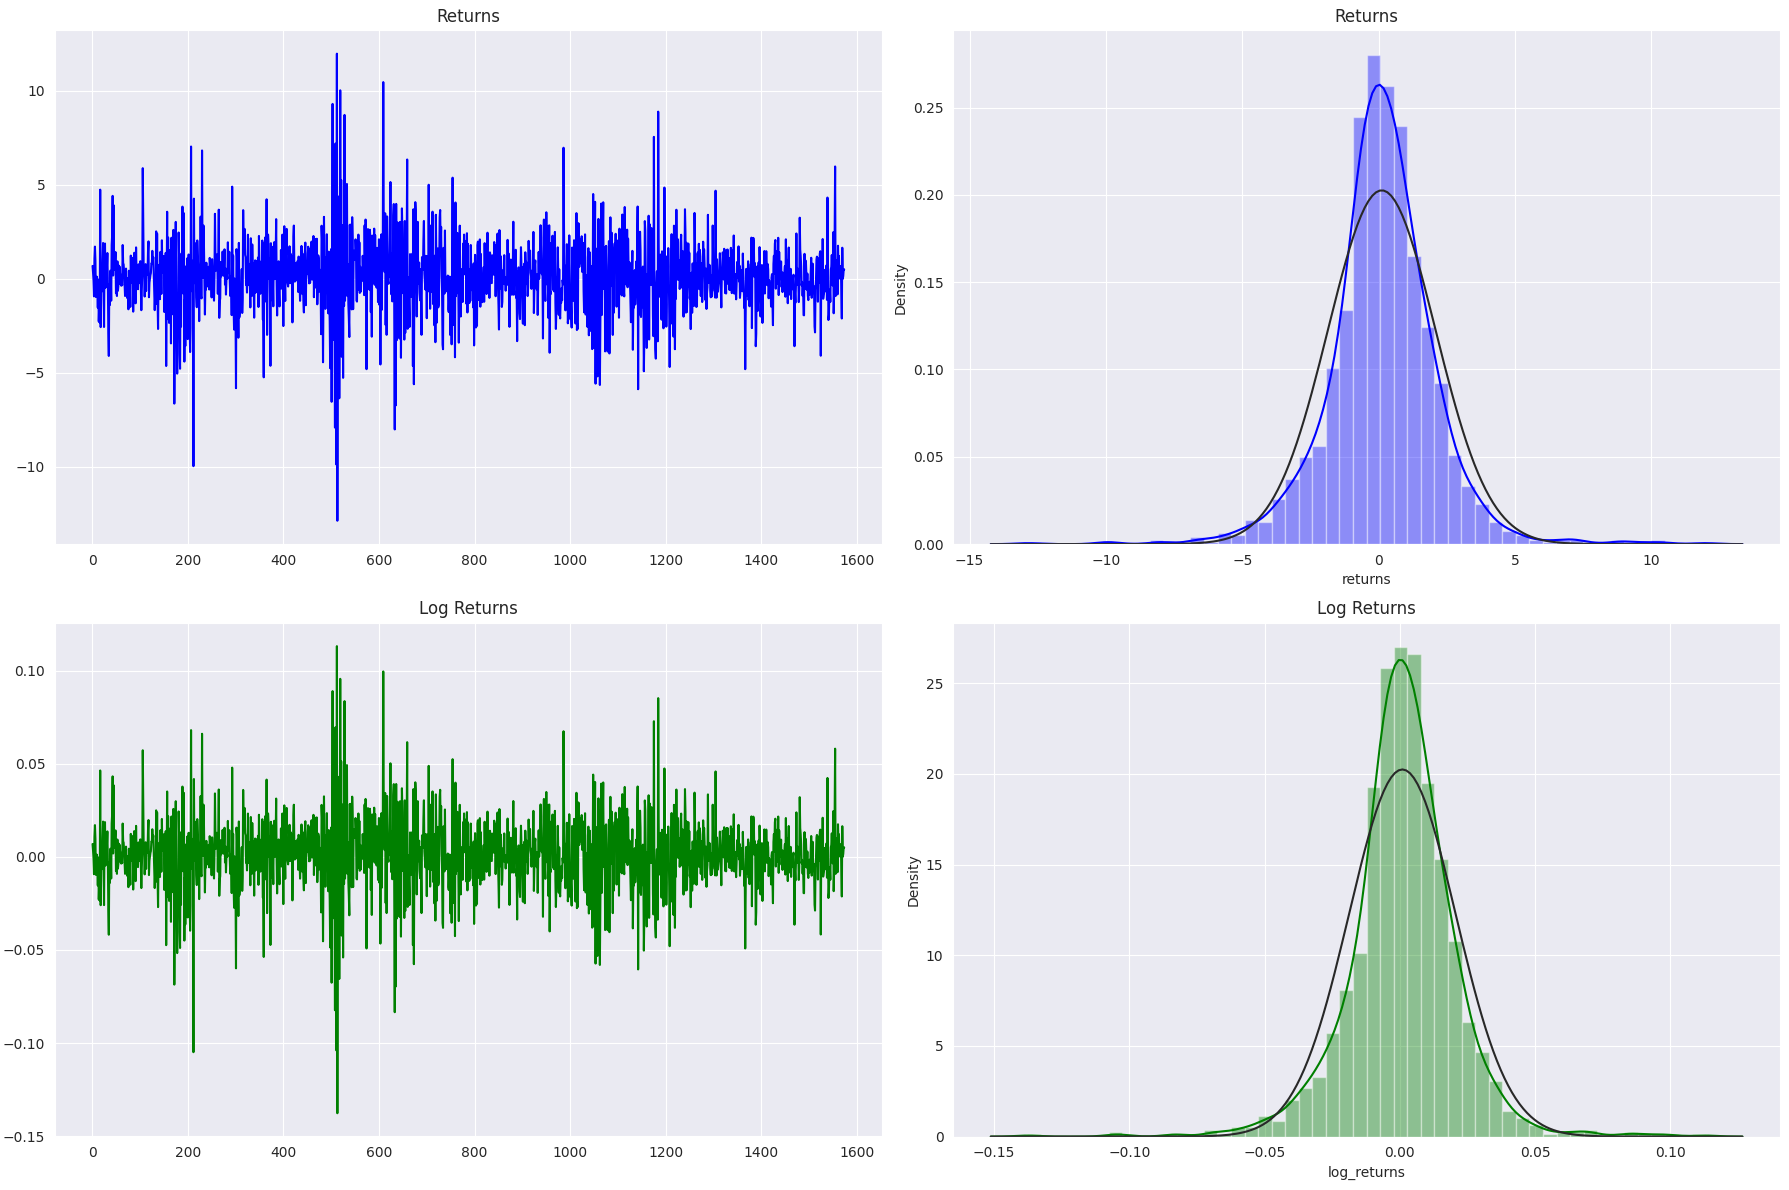

In [6]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()
    #plt.savefig(os.path.join(directory_to_img, 'returns_logreturns.png'), dpi=300, bbox_inches='tight')
    fig.show();

**Hàm để tính toán biến động thực tế (realized volatility) từ các lợi suất (returns) hàng ngày**

 Đoạn này tính toán biến động thực tế hàng ngày bằng cách lấy căn bậc hai của tổng của các bình phương của các lợi suất log trong chuỗi, sau đó chia cho n - 1 (số tự do trong mẫu, tương ứng với số quan sát trừ đi 1).

In [7]:

def realized_volatility_daily(series_log_return):
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

Đoạn mã trên tính toán biến động thực tế (realized volatility) cho các khoảng thời gian khác nhau và lưu kết quả vào DataFrame

intervals: Một danh sách chứa các khoảng thời gian (đơn vị: ngày) được sử dụng để tính toán biến động thực tế.

In [8]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

for i in intervals:
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

**Vẽ biểu đồ biến động thực tế (realized volatility) sử dụng các cửa sổ thời gian khác nhau**

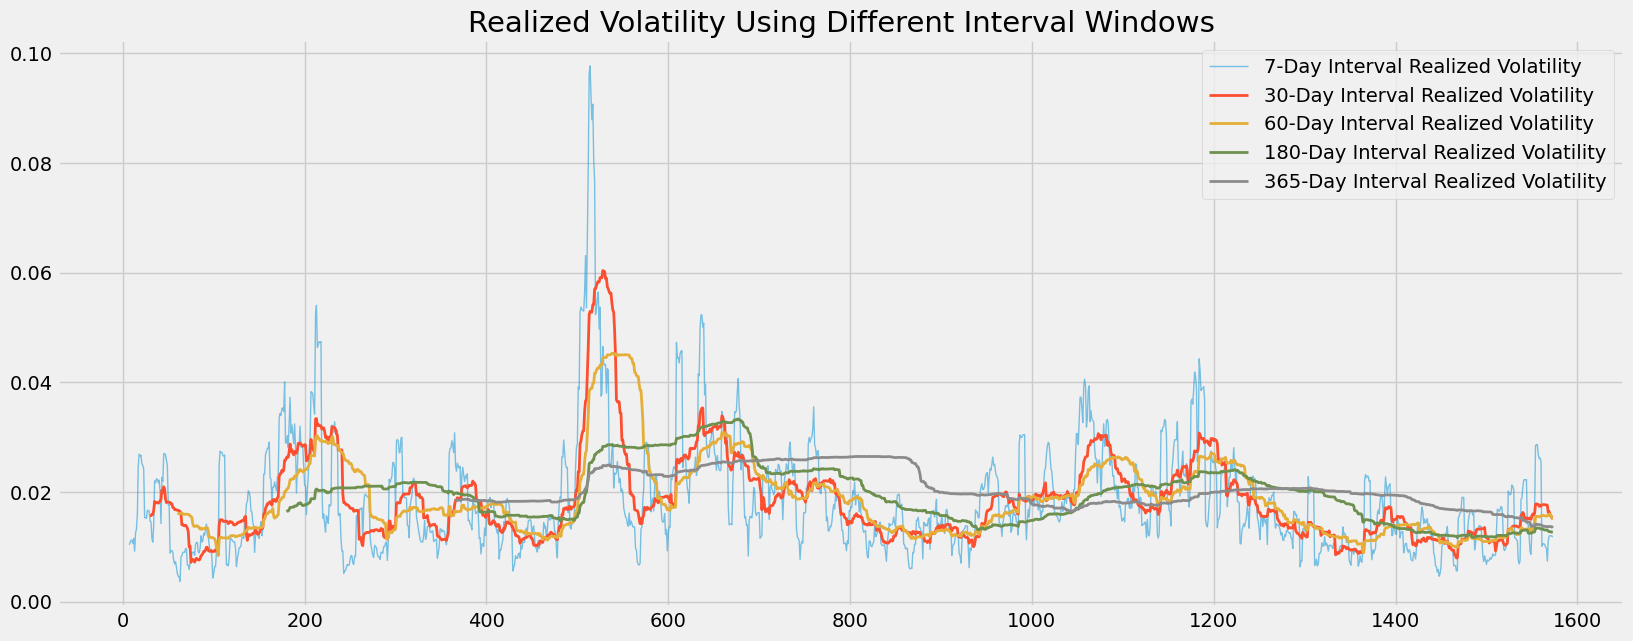

In [9]:
# CHANGING MATPLOTLIB STYLE
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility',
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})
#plt.savefig(os.path.join(directory_to_img, 'diff_intervals.png'), dpi=300, bbox_inches='tight')
plt.show()

**Tính biến động thực tế của khoảng thời gian hiện tại và của khoảng thời gian trong tương lai dựa trên lợi suất log của dữ liệu và sử dụng một cửa sổ thời gian cho mỗi trường hợp**

In [10]:
INTERVAL_WINDOW = 30
n_future = 7
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)
df['vol_future'] = df.log_returns.shift(-n_future) \
                                 .rolling(window=INTERVAL_WINDOW) \
                                 .apply(realized_volatility_daily)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1573 entries, 1 to 1573
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1573 non-null   object 
 1   Open         1573 non-null   float64
 2   High         1573 non-null   float64
 3   Low          1573 non-null   float64
 4   Close        1573 non-null   float64
 5   Adj Close    1573 non-null   float64
 6   Volume       1573 non-null   int64  
 7   returns      1573 non-null   float64
 8   log_returns  1573 non-null   float64
 9   vol_current  1544 non-null   float64
 10  vol_future   1537 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 147.5+ KB


** Split Train-Test Ratio

In [12]:
train_size = int(len(df) * 0.7)
test_size = len(df) - train_size

# Chỉ mục cho tập kiểm tra và tập huấn luyện
train_idx = df.index[:train_size +1 ]

test_idx = df.index[train_size :]




Chia dữ liệu biến động thực tế trong tương lai thành 2 phần tương ứng với nhãn của các tập train, test.

In [13]:
y_train = df.vol_future[train_idx]
y_test = df.vol_future[test_idx]

Chia dữ liệu tỷ suất lợi nhuận hàng ngày thành 2 phần tương ứng với nhãn của các tập train, test.

In [14]:
r_train = df.returns[train_idx]
r_test = df.returns[test_idx]

**Biến đổi một series dữ liệu bằng cách sử dụng scaler đã được fit từ trước**

In [15]:
def transform_volatility_to_scaler(scaler, tf_series):
    #Transform a series to a fitted scaler
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

MinMaxScaler chia mỗi giá trị trong biến thành một tỷ lệ tương đối so với giá trị tối thiểu và tối đa của biến để cân bằng tỷ lệ giữa các giá trị

In [16]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()
x_train = df.vol_current[train_idx]
x_test = df.vol_current[test_idx]
# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [17]:

# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [18]:
y_total_scaled = transform_volatility_to_scaler(scaler_vol,df.vol_future)

**Vẽ Nhãn**

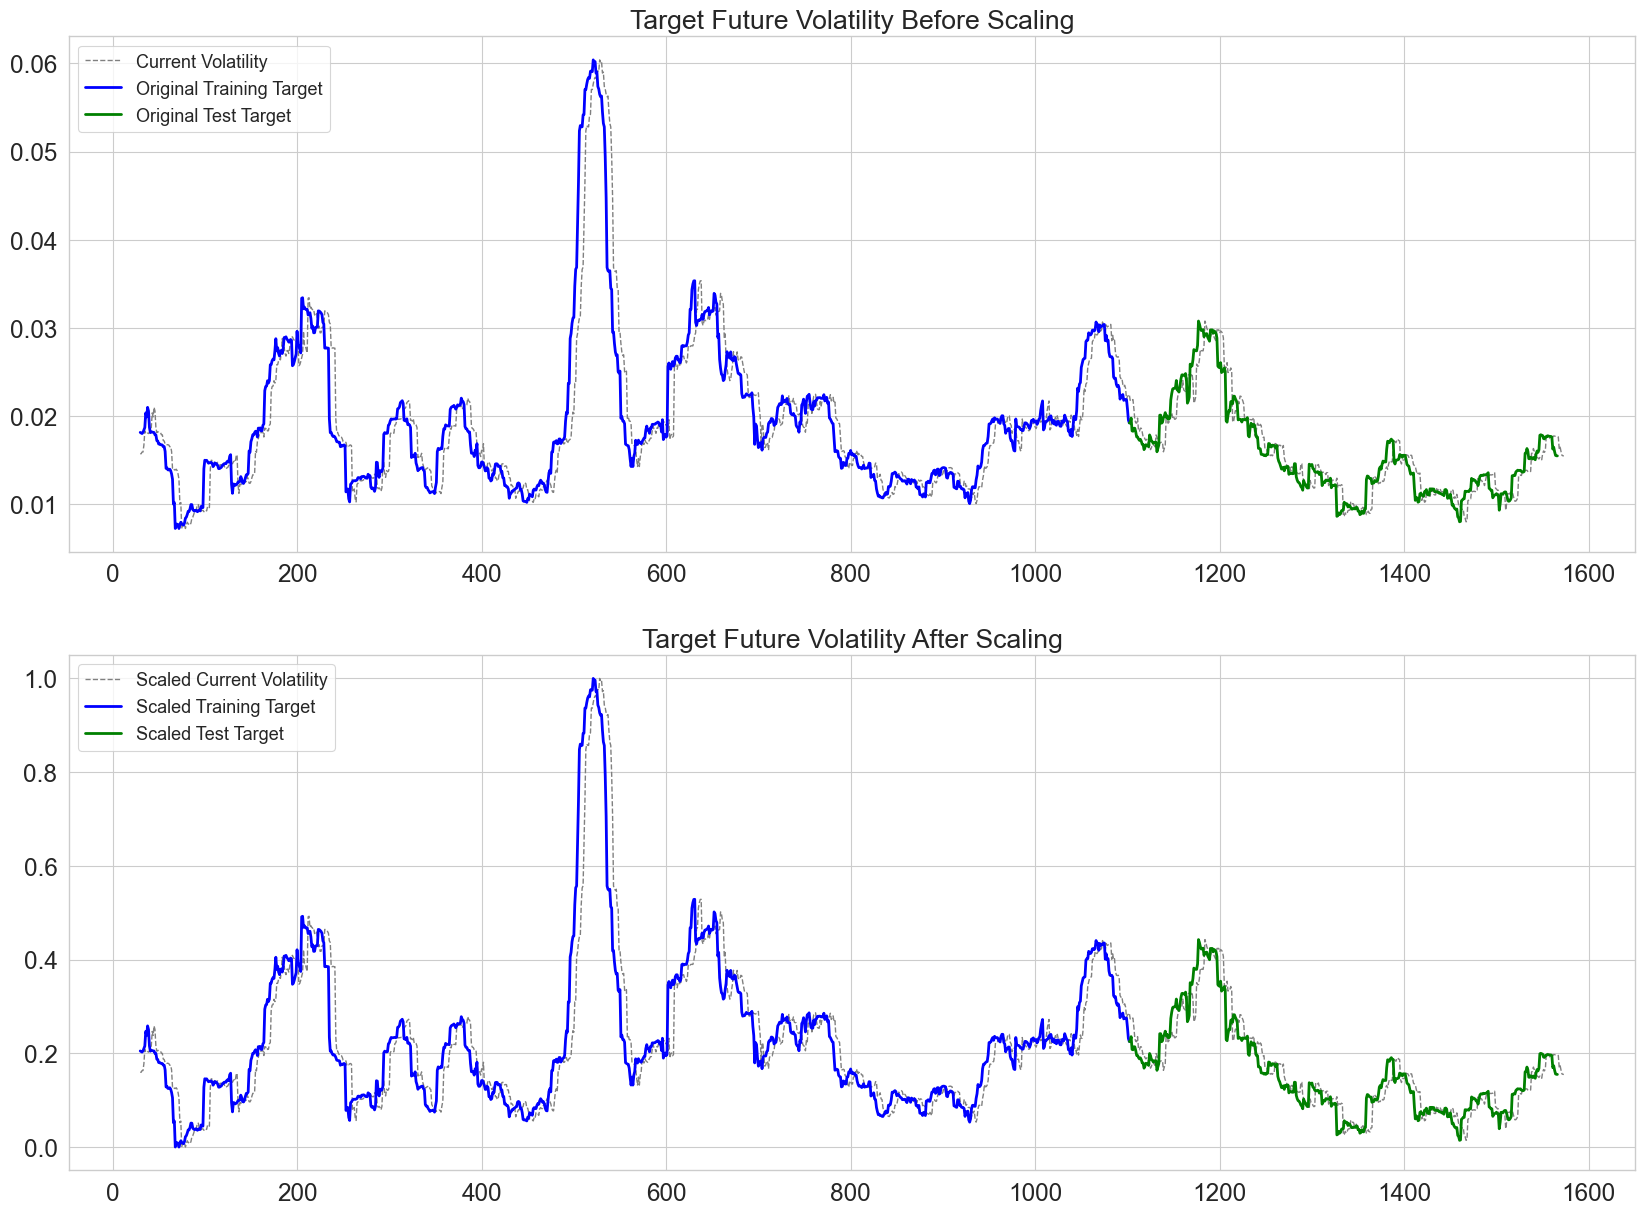

In [19]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    # ax1.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.vol_current),
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    # ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    #plt.savefig(os.path.join(directory_to_img, 'train_val_test_org_scled.png'),dpi=300, bbox_inches='tight')
    plt.show();

**Vẽ đầu vào**

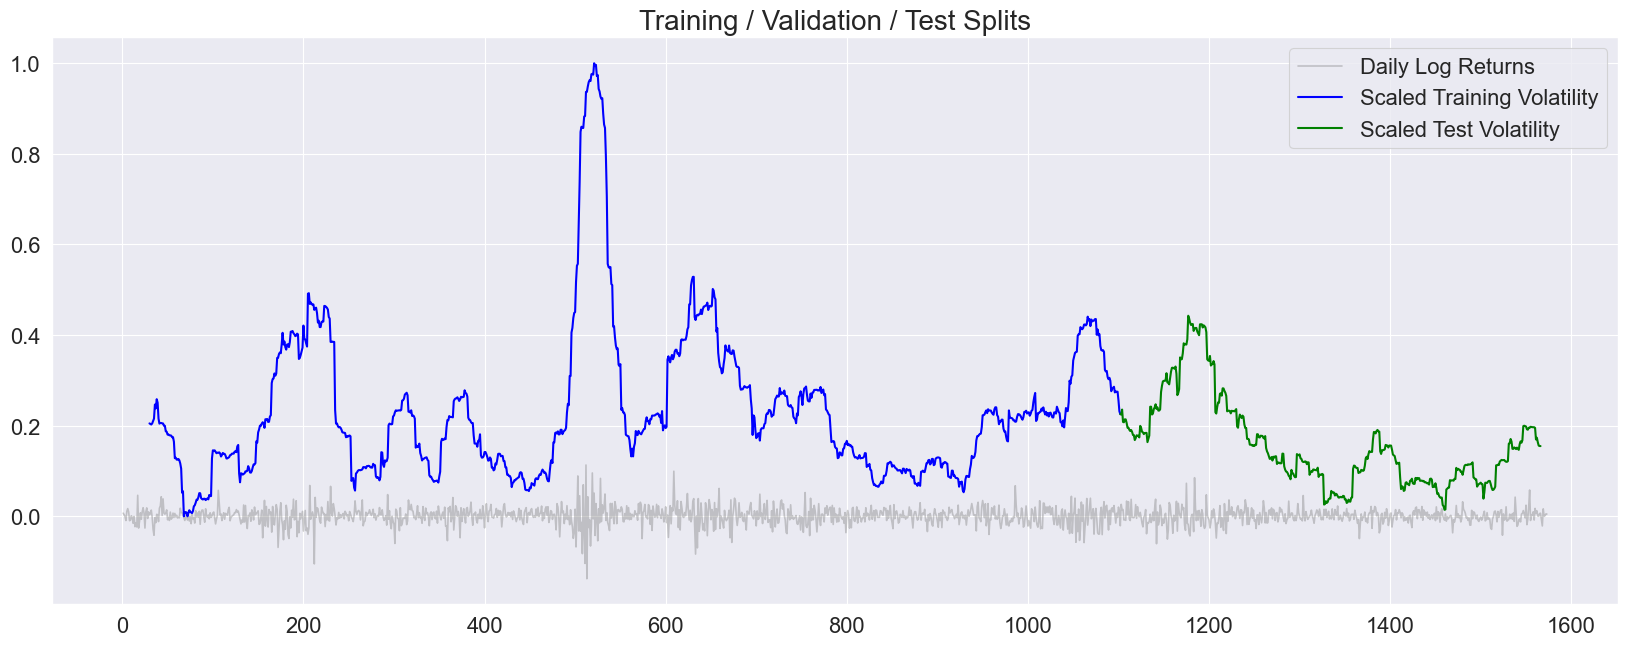

In [20]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue',
             label='Scaled Training Volatility', lw=1.5)
    # plt.plot(y_val_scaled, color='red',
    #          label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green',
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=20)
    plt.legend(frameon=True)
    #plt.savefig(os.path.join(directory_to_img, 'train_val_test.png'),dpi=300, bbox_inches='tight')
    plt.show();

# Hàm Đánh Giá

RMSE , MSE , MAPE

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def RMSE(y_true, y_pred):
    # Loại bỏ các giá trị nan trong y_true và tương ứng trong y_pred
    mask = ~np.isnan(y_true)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    mse = mean_squared_error(y_true_filtered, y_pred_filtered)
    output = np.sqrt(mse)
    return output

def MSE(y_true, y_pred):
    # Loại bỏ các giá trị nan trong y_true và tương ứng trong y_pred
    mask = ~np.isnan(y_true)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    output = mean_squared_error(y_true_filtered, y_pred_filtered)
    return output

def MAPE(y_true, y_pred):
    # Loại bỏ các giá trị nan trong y_true và tương ứng trong y_pred
    mask = ~np.isnan(y_true)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    output = mean_absolute_percentage_error(y_true_filtered, y_pred_filtered)
    return output
def MAE(y_true, y_pred):
    # Loại bỏ các giá trị nan trong y_true và tương ứng trong y_pred
    mask = ~np.isnan(y_true)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    output = mean_absolute_error(y_true_filtered, y_pred_filtered)
    return output

**Tạo ra một DataFrame với các cột 'Model', 'Validation MSE', 'Validation MAPE', và 'Validation RMSE'**

In [22]:
perf_df = pd.DataFrame(columns=['Model','MAE','MAPE', 'RMSE'])

**Hàm log_perf được sử dụng để ghi thông tin về hiệu suất của mô hình vào DataFrame perf_df để sau này dễ dàng so sánh**

In [23]:
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name,
                                       MAE(y_true, y_pred),
                                       MAPE(y_true, y_pred),
                                       RMSE(y_true, y_pred)]
    return perf_df

**Hàm viz_model được sử dụng để vẽ biểu đồ so sánh giữa giá trị dự đoán của mô hình và giá trị thực tế**

In [24]:
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        # plt.plot(x_val_scaled, color='gray',  ls=':',
        #         label=f"Scaled Current Daily Volatility")

        plt.plot(y_true, color='blue', lw=2,
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')

        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

# Basic GARCH

In [25]:
seed = 2024
from arch import arch_model
np.random.seed(seed)

In [26]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2249.21
Distribution:                  Normal   AIC:                           4506.43
Method:            Maximum Likelihood   BIC:                           4526.45
                                        No. Observations:                 1102
Date:                Fri, Jun 21 2024   Df Residuals:                     1101
Time:                        21:35:36   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2397  5.440e-02      4.407  1.051e-05 [  0.133,  0.3

 **Scale và biến đổi dữ liệu biến động điều kiện ước lượng bởi mô hình**

 Lấy dữ liệu biến động điều kiện được ước lượng từ kết quả của mô hình rồi fit scaler với dữ liệu biến động điều kiện ước lượng từ mô hình

In [27]:
def scale_tf_cond_vol(model_result):

    cond_vol = model_result.conditional_volatility

    scaler = MinMaxScaler()

    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

Lấy scaler đã được fit và dữ liệu biến động điều kiện đã được scale từ kết quả của mô hình result_1

In [28]:
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

Trực quan hóa dữ liệu biến động điều kiện ước lượng từ mô hình cùng với dữ liệu biến động điều kiện đã scale từ dữ liệu thực tế

In [29]:
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

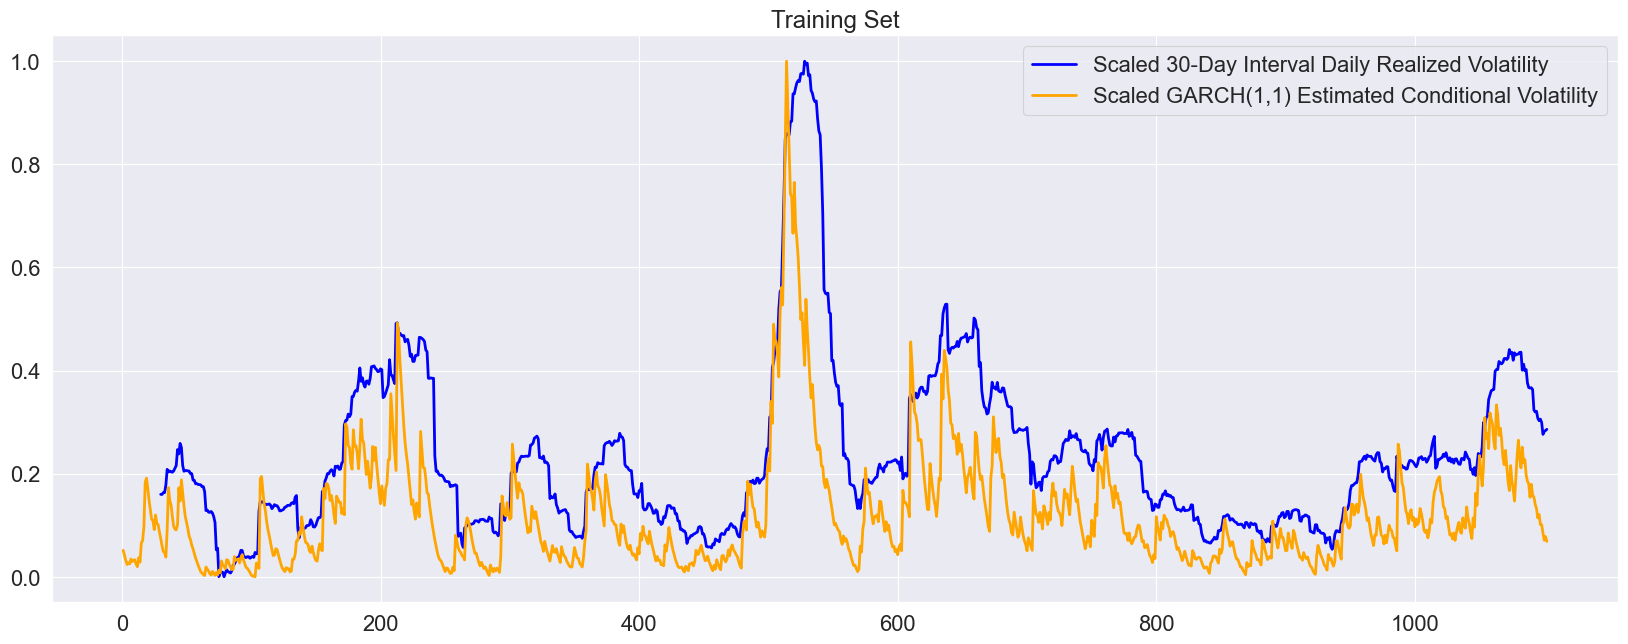

In [30]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

**Huấn luyện mô hình trên tất cả các dữ liệu trước đó và dự đoán biến động ở mỗi bước thời gian tiếp theo trong tập validation**

In [31]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(test_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = test_idx[i]
    train = df.returns[:idx]

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION 30 DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=test_idx)

**Biến đổi các dự đoán về biến động điều kiện sử dụng scaler đã được fit từ trước**

In [32]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

**Trực quan hóa dự đoán của mô hình so với giá trị thực tế trên tập validation**

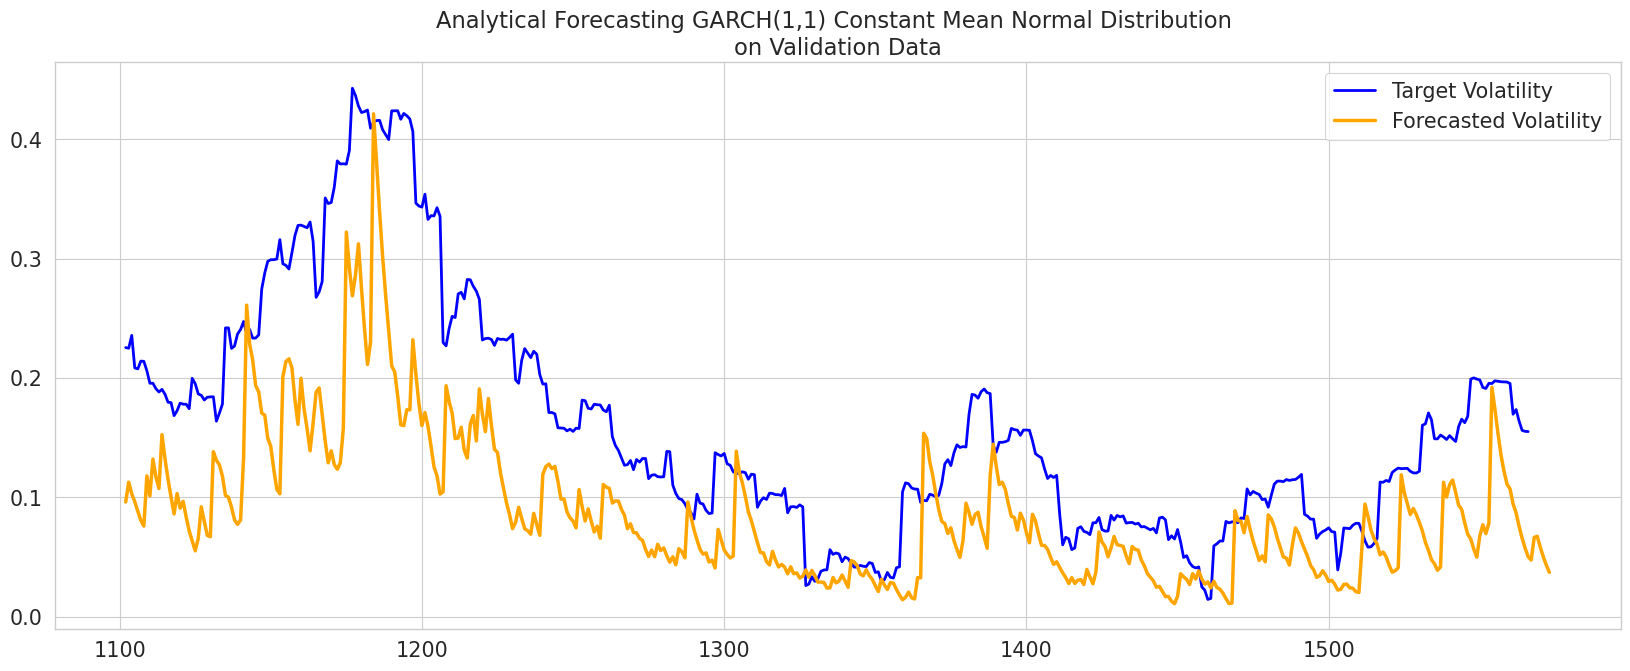

In [33]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_test_scaled, gm_1_preds_scaled,
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [34]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

**Ghi các giá trị của các metric (MSE, MAPE, RMSE) của mô hình  vào DataFrame**

In [35]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME

log_perf(y_test_scaled, gm_1_preds_scaled,'GARCH(1,1), Constant Mean, Normal Dist')

,Model,MAE,MAPE,RMSE
0,"GARCH(1,1), Constant Mean, Normal Dist",0.072986,0.449582,0.090984


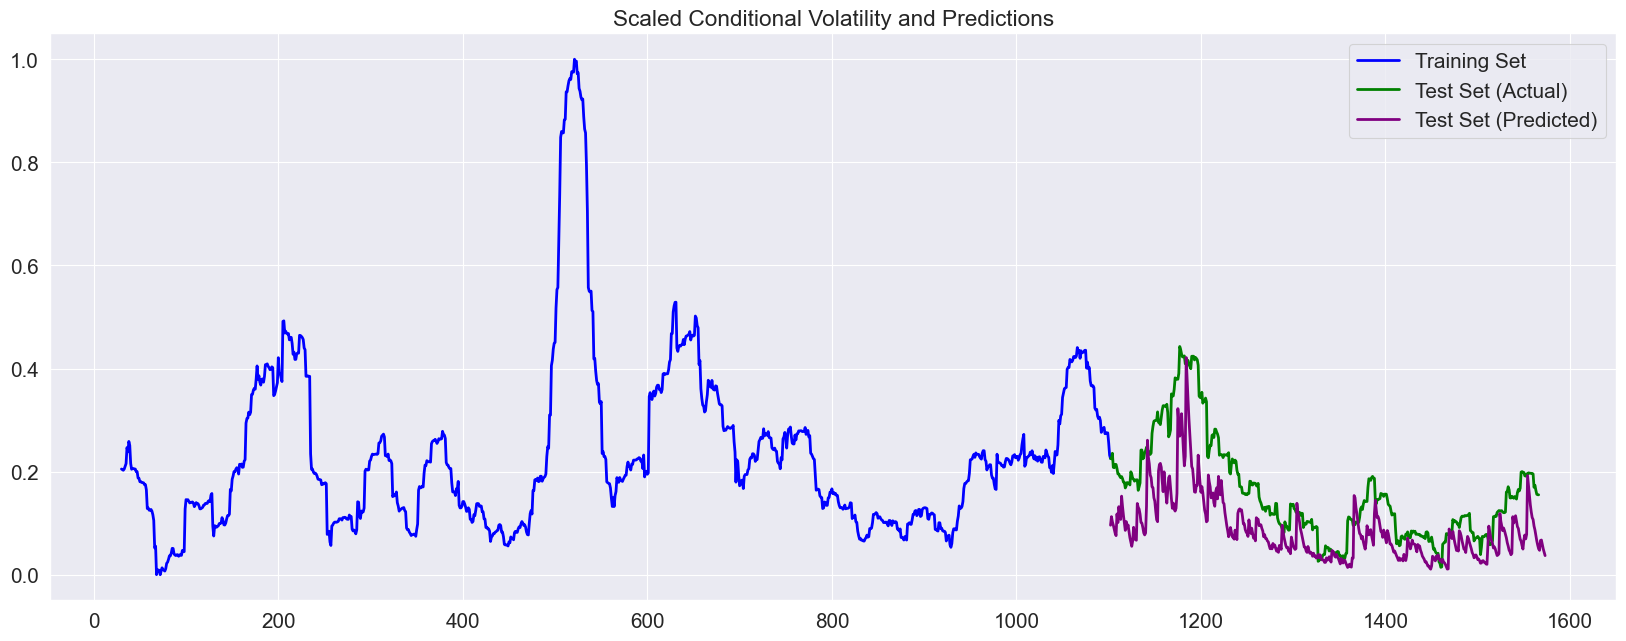

In [36]:
def viz_cond_vol_total(y_train_scaled, y_test_scaled, y_test_pred_scaled, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        # Plot training set
        ax.plot(y_train_scaled, color='blue', lw=2,
                label='Training Set')
        # Plot test set
        ax.plot(y_test_scaled.index, y_test_scaled.values, color='green', lw=2,
                label='Test Set (Actual)')
        ax.plot(y_test_pred_scaled.index, y_test_pred_scaled.values, color='purple', lw=2,
                label='Test Set (Predicted)')

        ax.set_title('Scaled Conditional Volatility and Predictions')
        plt.legend()
        plt.show()

# Call the function to visualize
viz_cond_vol_total(y_train_scaled, y_test_scaled, gm_1_preds_scaled, 'GARCH(1,1), Constant Mean, Normal Dist')


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1573 entries, 1 to 1573
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1573 non-null   object 
 1   Open         1573 non-null   float64
 2   High         1573 non-null   float64
 3   Low          1573 non-null   float64
 4   Close        1573 non-null   float64
 5   Adj Close    1573 non-null   float64
 6   Volume       1573 non-null   int64  
 7   returns      1573 non-null   float64
 8   log_returns  1573 non-null   float64
 9   vol_current  1544 non-null   float64
 10  vol_future   1537 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 179.8+ KB


**Dự đoán 30 ngày tiếp theo**

In [38]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts_30 = []
idx = 1573
train = df.returns[:idx]
# ITERATE OVER EACH TIME STEP IN THE TEST SET
for i in range(1,31):


    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values

    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))
    train = pd.concat([train, pd.Series(pred, index=[idx+i])])

    # APPEND TO rolling_forecasts_test LIST
    rolling_forecasts_30.append(pred)

In [39]:
# Define the index range from 1259 to 1288
index_range = range(1573, 1603)
# Convert the list to a pandas Series with 30_idx as index
gm_1_preds_next_30 = pd.Series(rolling_forecasts_30,index_range)
gm_1_preds_30 = transform_volatility_to_scaler(scaler_garch, gm_1_preds_next_30)

**Dự đoán 60 ngày tiếp theo**

In [40]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts_60 = []
# idx = 1258
idx = 1573
train = df.returns[:idx]
# ITERATE OVER EACH TIME STEP IN THE TEST SET
for i in range(1,61):


    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values

    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))
    train = pd.concat([train, pd.Series(pred, index=[idx+i])])

    # APPEND TO rolling_forecasts_test LIST
    rolling_forecasts_60.append(pred)

In [41]:
# Define the index range from 1259 to 1318
index_range = range(1573, 1633)
# Convert the list to a pandas Series with 30_idx as index
gm_1_preds_next_60 = pd.Series(rolling_forecasts_60,index_range)
gm_1_preds_60 = transform_volatility_to_scaler(scaler_garch, gm_1_preds_next_60)

**Dự đoán 90 ngày tiếp theo**

In [42]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts_90 = []
idx = 1573
train = df.returns[:idx]
# ITERATE OVER EACH TIME STEP IN THE TEST SET
for i in range(1,91):


    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values

    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))
    train = pd.concat([train, pd.Series(pred, index=[idx+i])])

    # APPEND TO rolling_forecasts_test LIST
    rolling_forecasts_90.append(pred)

In [43]:
# Define the index range
index_range = range(1573, 1663)
# Convert the list to a pandas Series with 30_idx as index
gm_1_preds_next_90 = pd.Series(rolling_forecasts_90,index_range)
gm_1_preds_90 = transform_volatility_to_scaler(scaler_garch, gm_1_preds_next_90)

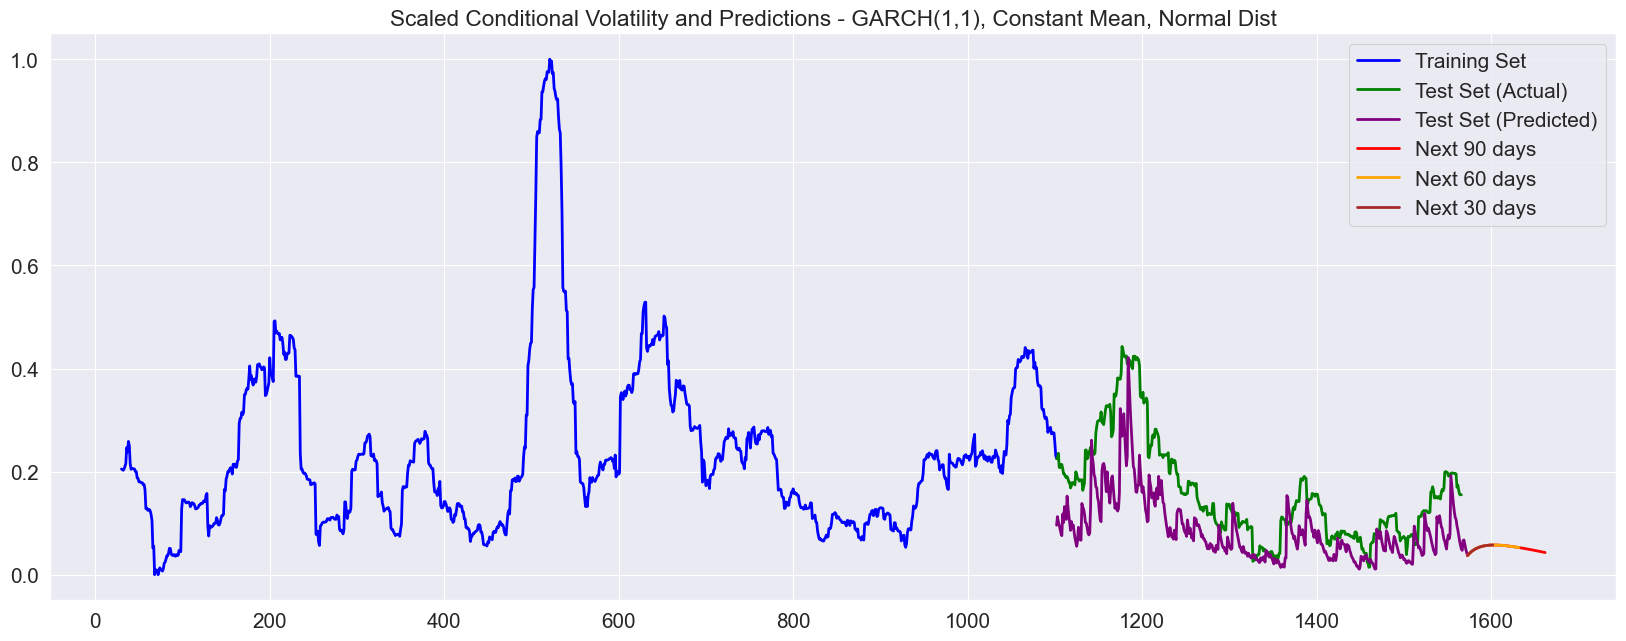

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

def viz_cond_vol_total_30_60_90(y_train_scaled, y_test_scaled, y_test_pred_scaled,
                                gm_1_preds_30, gm_1_preds_60, gm_1_preds_90, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18, 7))

        # Plot training set
        ax.plot(y_train_scaled, color='blue', lw=2, label='Training Set')

        # Plot test set
        ax.plot(y_test_scaled.index, y_test_scaled.values, color='green', lw=2, label='Test Set (Actual)')
        ax.plot(y_test_pred_scaled.index, y_test_pred_scaled.values, color='purple', lw=2, label='Test Set (Predicted)')

        # Plot 90 days forecast
        ax.plot(gm_1_preds_90.index, gm_1_preds_90.values, color='red', lw=2, label='Next 90 days')

        # Plot 60 days forecast
        ax.plot(gm_1_preds_60.index, gm_1_preds_60.values, color='orange', lw=2, label='Next 60 days')

        # Plot 30 days forecast
        ax.plot(gm_1_preds_30.index, gm_1_preds_30.values, color='brown', lw=2, label='Next 30 days')

        ax.set_title(f'Scaled Conditional Volatility and Predictions - {model_name}')
        plt.legend()
        plt.show()
        return fig

# Example call to the function with dummy data (replace with actual data)
fig_90 = viz_cond_vol_total_30_60_90(y_train_scaled,  y_test_scaled , gm_1_preds_scaled,
                                    gm_1_preds_30, gm_1_preds_60, gm_1_preds_90, 'GARCH(1,1), Constant Mean, Normal Dist')


# GJR-GARCH

In [45]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1,
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -2211.38
Distribution:      Standardized Skew Student's t   AIC:                           4436.77
Method:                       Maximum Likelihood   BIC:                           4471.80
                                                   No. Observations:                 1102
Date:                           Fri, Jun 21 2024   Df Residuals:                     1101
Time:                                   21:35:46   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [46]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

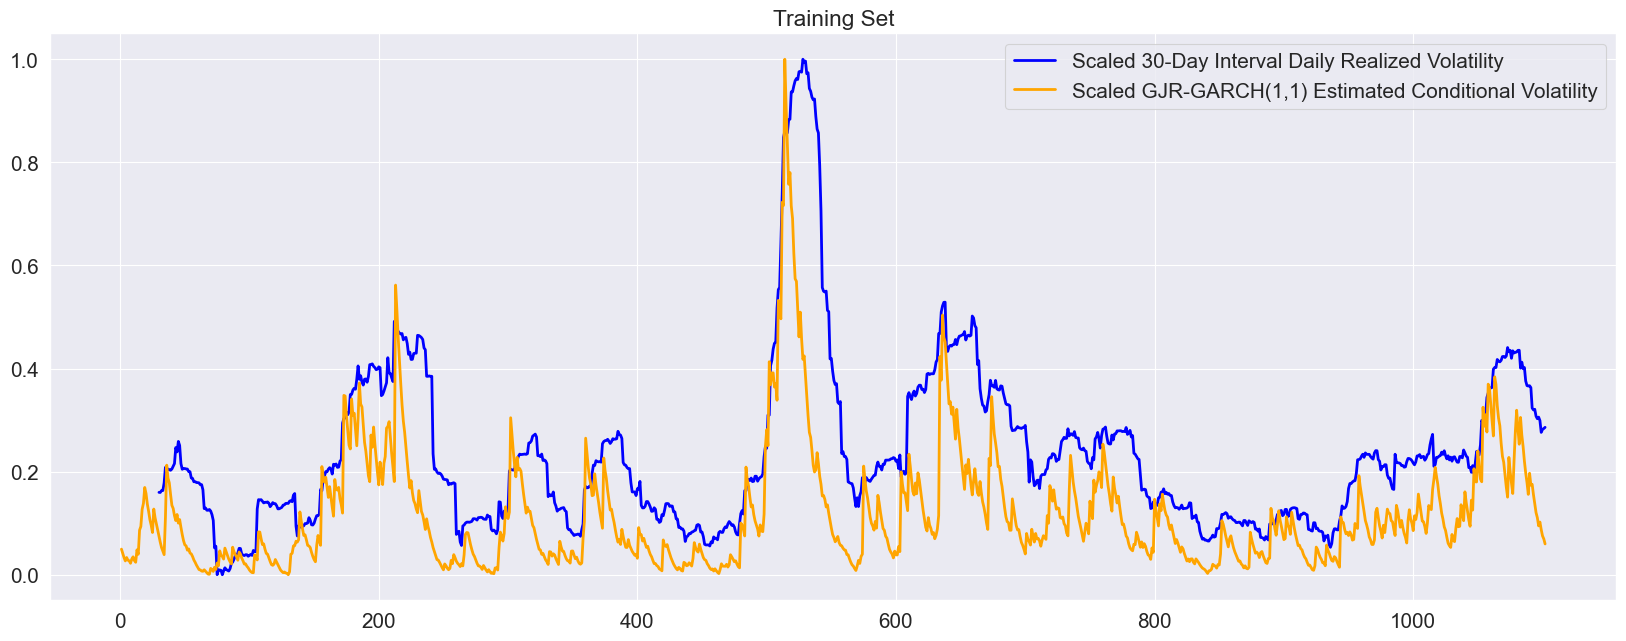

In [47]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [48]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(test_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = test_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=test_idx)

In [49]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

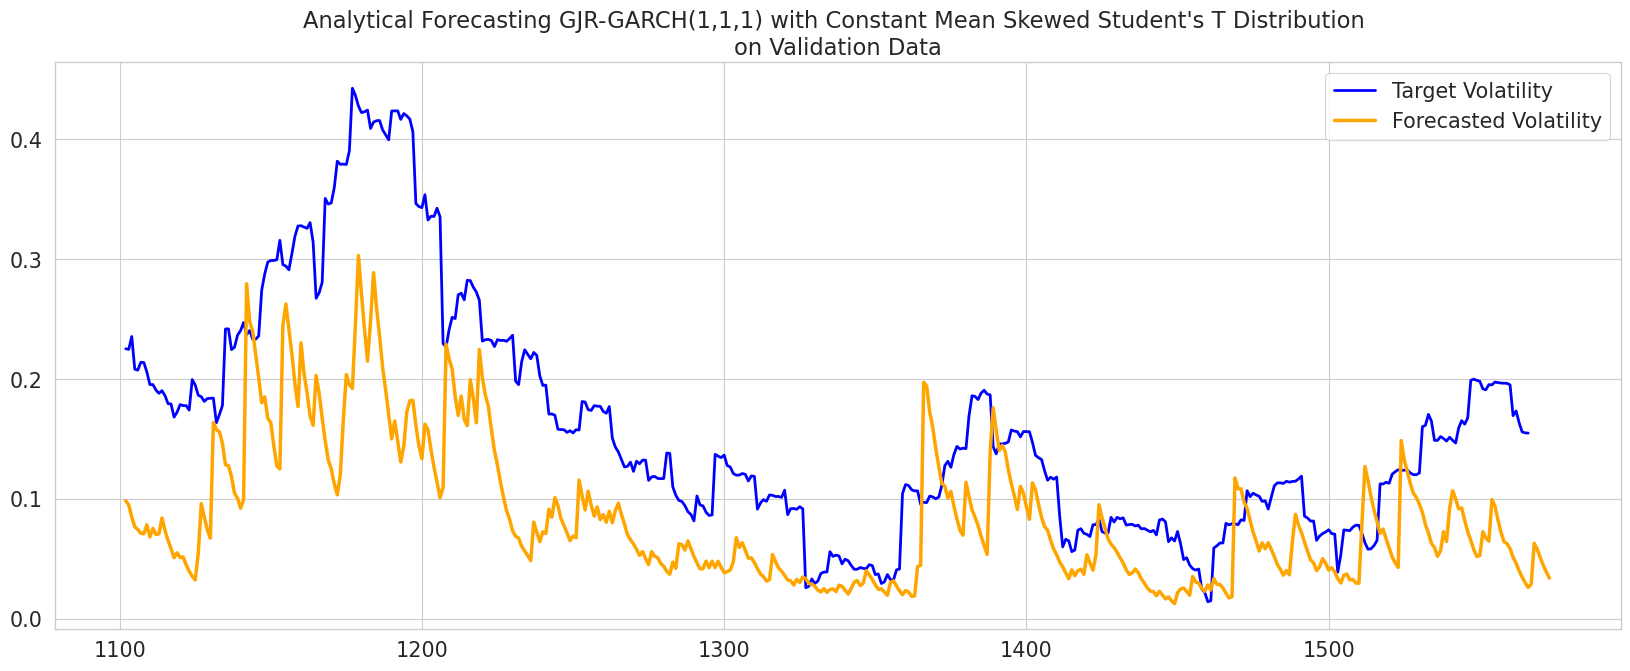

In [50]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_test_scaled, gjr_1_preds_scaled,
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [51]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_test_scaled, gjr_1_preds_scaled,
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

,Model,MAE,MAPE,RMSE
0,"GARCH(1,1), Constant Mean, Normal Dist",0.072986,0.449582,0.090984
1,"Analytical GJR-GARCH(1,1,1), Constant Mean, Sk...",0.077758,0.476156,0.097604


**Dự đoán 30 ngày tiếp theo**

In [52]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts_30 = []
idx = 1573
train = df.returns[:idx]
# ITERATE OVER EACH TIME STEP IN THE TEST SET
for i in range(1,31):


    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))
    train = pd.concat([train, pd.Series(pred, index=[idx+i])])

    # APPEND TO rolling_forecasts_test LIST
    rolling_forecasts_30.append(pred)

In [53]:
# Define the index range from 1259 to 1288
index_range = range(1573, 1603)
# Convert the list to a pandas Series with 30_idx as index
gjr__preds_next_30 = pd.Series(rolling_forecasts_30,index_range)
gjr__preds_30 = transform_volatility_to_scaler(scaler_garch, gjr__preds_next_30)

**Dự đoán 60 ngày tiếp theo

In [54]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts_60 = []
# idx = 1258
idx = 1573
train = df.returns[:idx]
# ITERATE OVER EACH TIME STEP IN THE TEST SET
for i in range(1,61):


    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))
    train = pd.concat([train, pd.Series(pred, index=[idx+i])])

    # APPEND TO rolling_forecasts_test LIST
    rolling_forecasts_60.append(pred)


In [55]:
# Define the index range from 1259 to 1288
index_range = range(1573, 1633)
# Convert the list to a pandas Series with 30_idx as index
gjr__preds_next_60 = pd.Series(rolling_forecasts_60,index_range)
gjr__preds_60 = transform_volatility_to_scaler(scaler_garch, gjr__preds_next_60)

**Dự đoán 90 ngày tiếp theo**

In [56]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts_90 = []
idx = 1573
train = df.returns[:idx]
# ITERATE OVER EACH TIME STEP IN THE TEST SET
for i in range(1,91):


    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future,
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))
    train = pd.concat([train, pd.Series(pred, index=[idx+i])])

    # APPEND TO rolling_forecasts_test LIST
    rolling_forecasts_90.append(pred)

In [57]:
# Define the index range from 1259 to 1288
index_range = range(1573, 1663)
# Convert the list to a pandas Series with 30_idx as index
gjr__preds_next_90 = pd.Series(rolling_forecasts_90,index_range)
gjr__preds_90 = transform_volatility_to_scaler(scaler_garch, gjr__preds_next_90)

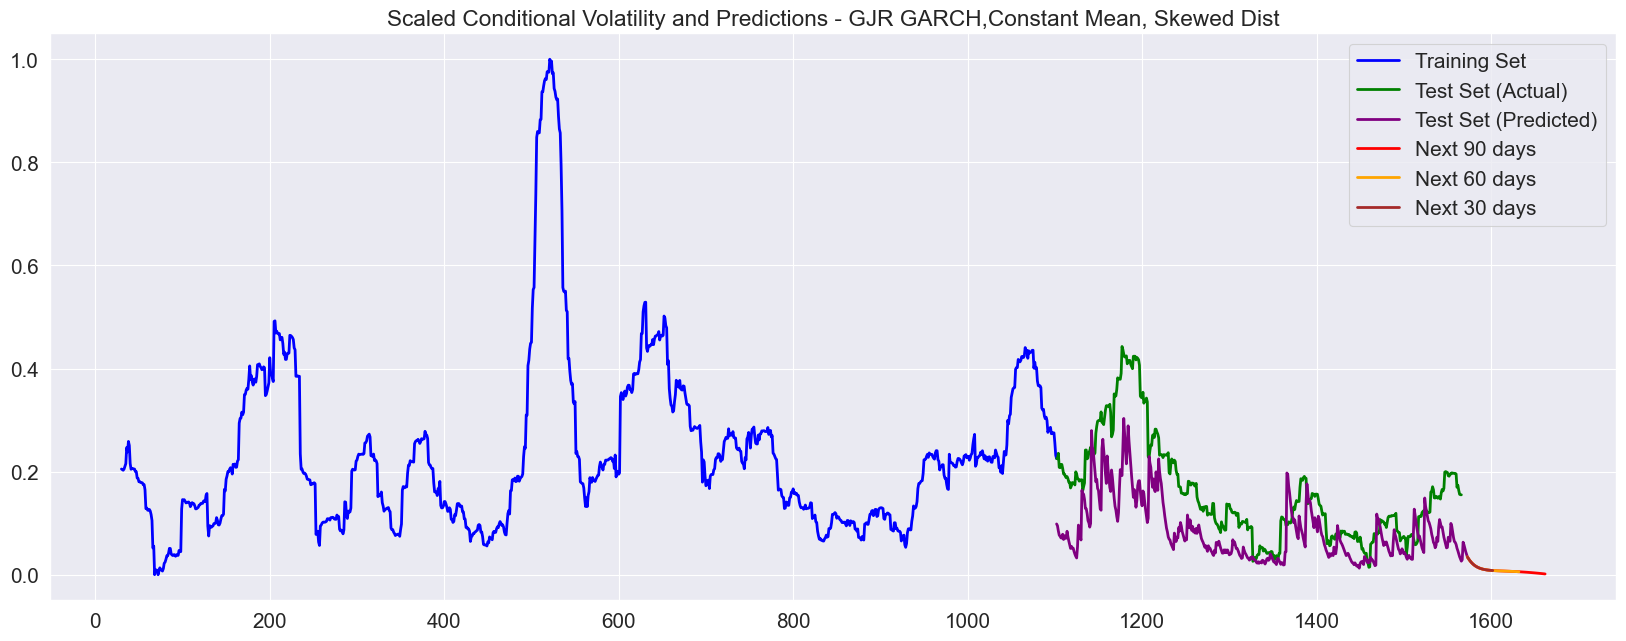

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

def viz_cond_vol_total_30_60_90(y_train_scaled, y_test_scaled, y_test_pred_scaled,
                                gm_1_preds_30, gm_1_preds_60, gm_1_preds_90, model_name):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(18, 7))

        # Plot training set
        ax.plot(y_train_scaled, color='blue', lw=2, label='Training Set')

        # Plot test set
        ax.plot(y_test_scaled.index, y_test_scaled.values, color='green', lw=2, label='Test Set (Actual)')
        ax.plot(y_test_pred_scaled.index, y_test_pred_scaled.values, color='purple', lw=2, label='Test Set (Predicted)')

        # Plot 90 days forecast
        ax.plot(gm_1_preds_90.index, gm_1_preds_90.values, color='red', lw=2, label='Next 90 days')

        # Plot 60 days forecast
        ax.plot(gm_1_preds_60.index, gm_1_preds_60.values, color='orange', lw=2, label='Next 60 days')

        # Plot 30 days forecast
        ax.plot(gm_1_preds_30.index, gm_1_preds_30.values, color='brown', lw=2, label='Next 30 days')

        ax.set_title(f'Scaled Conditional Volatility and Predictions - {model_name}')
        plt.legend()
        plt.show()
        return fig

# Example call to the function with dummy data (replace with actual data)
fig_90 = viz_cond_vol_total_30_60_90(y_train_scaled, y_test_scaled, gjr_1_preds_scaled,
                                    gjr__preds_30, gjr__preds_60, gjr__preds_90, 'GJR GARCH,Constant Mean, Skewed Dist')
